#Analysis

### 1. **`pred_prob` (Predicted Probability)**

* **What it is**: Model-generated probability that the account will be recovered (i.e., the customer will repay).
* **Use**: Target variable for calibration models, or benchmarking new models.
* **Significance**: Acts as a baseline score—your new model should improve upon or replicate its performance.

---

### 2. **`actual_bucket`, `current_bucket`, `bucket_new`**

* **What it is**: Delinquency bucket (e.g., “X+30” means 30+ days past due). Indicates how overdue a customer is.
* **Significance**: Higher buckets = harder to recover = lower propensity to repay.

---

### 3. **`cibil_score_bands`**

* **What it is**: Credit score range (from India's CIBIL bureau).
* **Use**: Proxy for customer creditworthiness.
* **Significance**: One of the **strongest predictors** of repayment. Higher bands → more likely to repay.

---

### 4. **`cc_max_dpd_l6m_band`, `unsec_max_dpd_l6m_band`, `sec_max_dpd_l6m_band`**

* **What it is**: Maximum days past due (DPD) for different types of loans over last 6 months.
* **Use**: Indicates behavior across product types — risky if DPD is high in multiple accounts.
* **Significance**: Predictive of chronic delinquents vs. temporary defaulters.

---

### 5. **`n_trades_offus_paid_l1m/l3m/l6m`**

* **What it is**: Number of external bank accounts paid recently.
* **Use**: Measures active repayment behavior elsewhere.
* **Significance**: A customer paying others but not you may signal **strategic default** or **willingness to pay if nudged**.

---

### 6. **`last_paid_amt`, `last_payment_date`**

* **What it is**: Amount and recency of last payment.
* **Use**: Strong behavioral indicator; can be transformed to "days since last payment".
* **Significance**: Recent payers are far more likely to recover than those inactive for long.

---

### 7. **`enr` (Exposure at Risk)**

* **What it is**: Amount at risk or outstanding amount.
* **Use**: Use as an input and also to prioritize by **expected value of recovery** (`pred_prob * enr`).
* **Significance**: High ENR + high probability → high-value target. Also useful to bin customers into risk tiers.

---

### 8. **`vintage_band`**

* **What it is**: Age of the loan (e.g., <3 months, 3–6 months, >1 year).
* **Use**: Early-stage vs. late-stage recovery strategy. Older accounts are harder to recover.

---

### 9. **`portfolio_type`**

* **What it is**: Type of loan product (Credit Card, Personal Loan, etc.).
* **Use**: Behavior varies by product. Credit cards are more volatile, unsecured loans riskier.
* **Significance**: Portfolio-specific models often outperform generalized models.

---

### 10. **`propensity`, `tag`, `segment`, `priority_segments_bureau`**

* **What it is**: Existing classifications based on digital behavior, bureau tags, or internal models.
* **Use**: Great as inputs or to create **interaction variables** (e.g., high score + risky tag = volatile).
* **Significance**: Often contain **latent intelligence** from earlier models or heuristics.

---

### 11. **`cycle_dpd`, `current_dpd`**

* **What it is**: Total days past due — numeric form of buckets.
* **Use**: Raw numeric values often more useful than buckets in regression models.
* **Significance**: Captures depth of delinquency; good feature for logistic regression or gradient boosting.

---

### 12. **`exclusion_flag_*`, `final_exclusion_flag`**

* **What it is**: Binary indicators for accounts that are legally blocked, already settled, or excluded from recovery.
* **Use**: Must be used to **filter out** training data — don’t learn from customers who are no longer collectible.
* **Significance**: Avoids model contamination; also useful for **rule-based overrides** post-score.

---

### 13. **`digi_flag`, `app_login_latest`**

* **What it is**: Indicates if the customer is active digitally or last logged into the app.
* **Use**: Helps tailor strategy: digital nudges vs. field agents.
* **Significance**: A digital customer is often **cheaper to recover** and **more responsive** to campaigns.



In [ ]:
import pandas as pd
file_path = "/content/predixion_recovery_fields.csv"
df=pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17904 entries, 0 to 17903
Data columns (total 62 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   realid                               17904 non-null  int64  
 1   pred_prob                            17904 non-null  float64
 2   decile                               17904 non-null  int64  
 3   app_latest_city                      17697 non-null  object 
 4   app_latest_country                   17904 non-null  object 
 5   tag                                  17904 non-null  object 
 6   new_tag                              17904 non-null  object 
 7   state                                17904 non-null  object 
 8   bill_date                            17904 non-null  object 
 9   bank_bill                            17904 non-null  object 
 10  enr                                  17904 non-null  float64
 11  status                      

/tmp/ipython-input-3-2894505452.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_summary.values, y=missing_summary.index, palette="viridis")


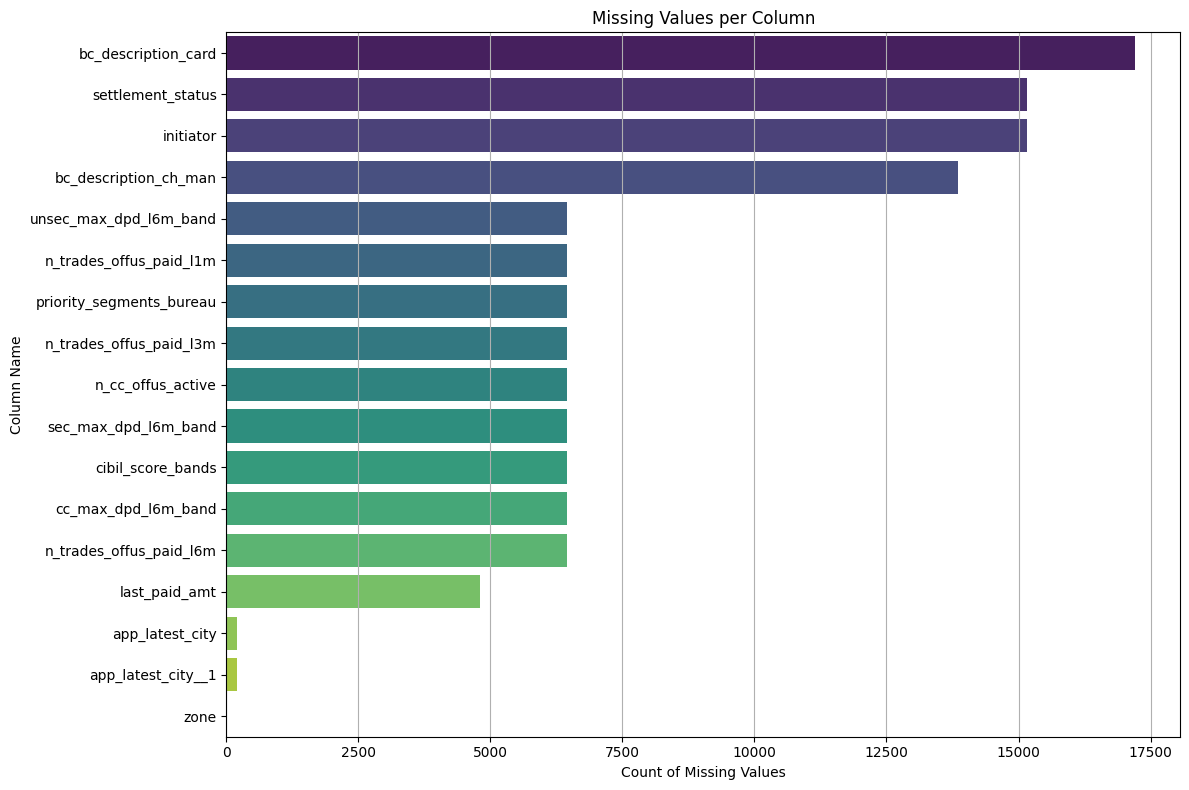

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Summarize missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]

# Step 2: Plot missing data
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_summary.values, y=missing_summary.index, palette="viridis")
plt.title("Missing Values per Column")
plt.xlabel("Count of Missing Values")
plt.ylabel("Column Name")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


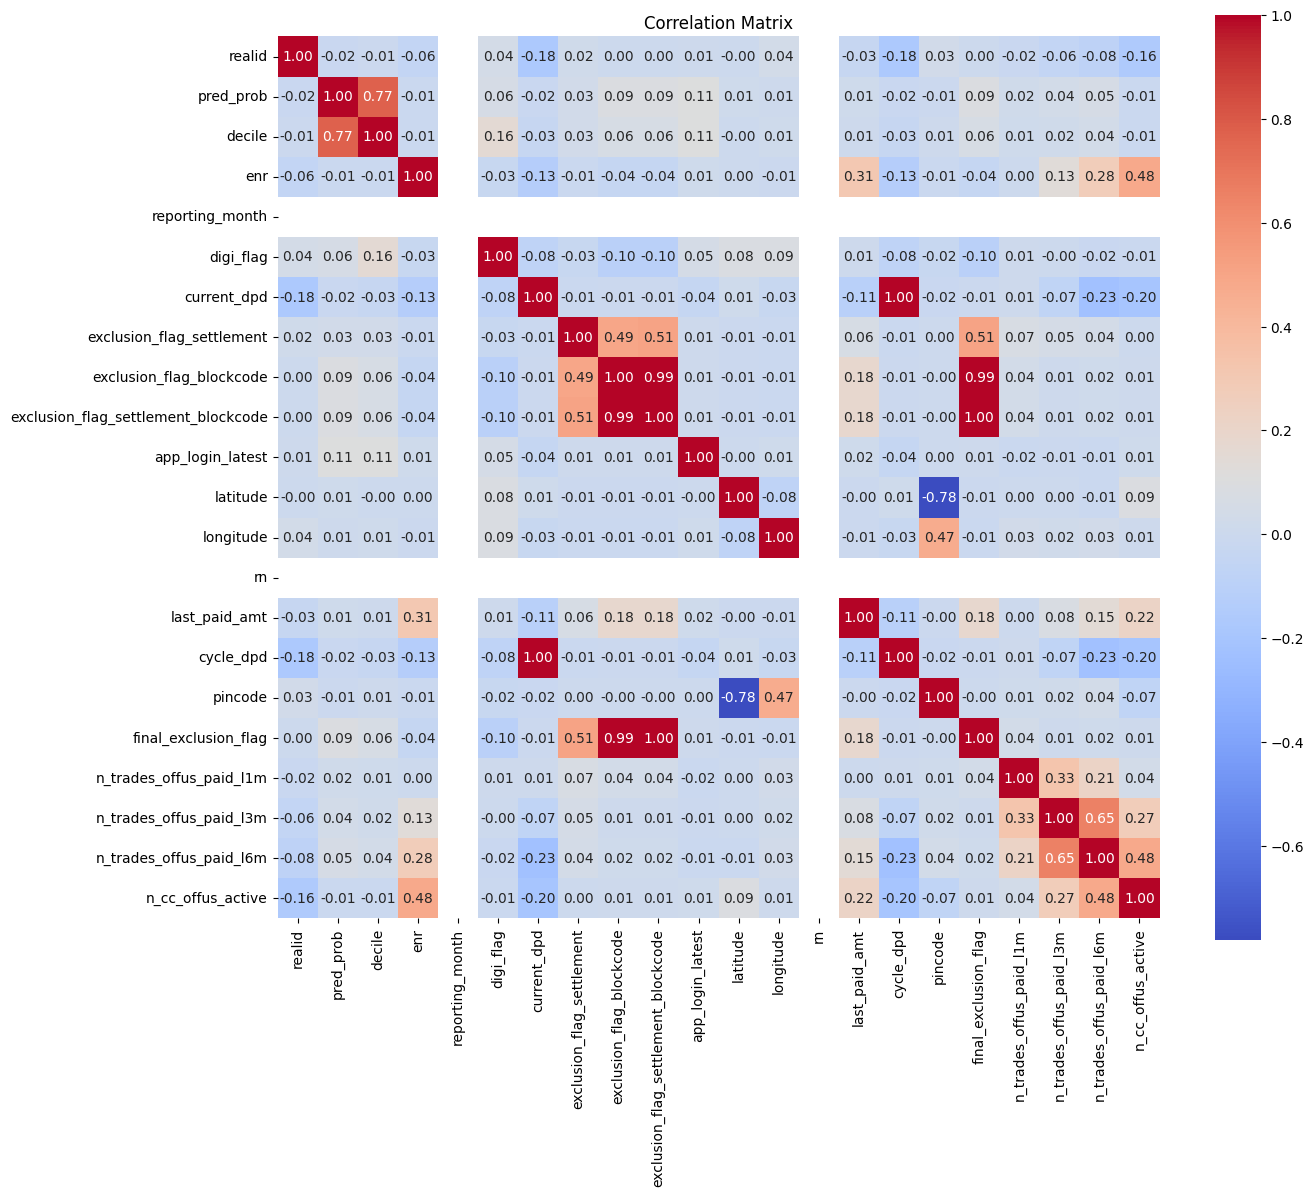

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


#Data preprocessing

In [ ]:
import pandas as pd
df=pd.read_csv('/content/predixion_recovery_fields.csv')
df.head()

,realid,pred_prob,decile,app_latest_city,app_latest_country,tag,new_tag,state,bill_date,bank_bill,...,n_trades_offus_paid_l1m,n_trades_offus_paid_l3m,n_trades_offus_paid_l6m,cibil_score_bands,cc_max_dpd_l6m_band,unsec_max_dpd_l6m_band,sec_max_dpd_l6m_band,n_cc_offus_active,priority_segments_bureau,cycle
0,2773820464605168999,0.208098,8,Jaipur,India,High_Propensity,High_Propensity,Rajasthan,18-05-2025,BOB,...,0.0,3.0,4.0,4. 640-669,7. 361+ DPD,7. 361+ DPD,8. NA,8.0,P9: Others,Recovery
1,2774089235957810551,0.617772,9,Hyderabad,India,High_Propensity,FED_pool,Telangana,14-05-2025,FED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Recovery
2,2774975499514939007,0.198212,8,Delhi,India,High_Propensity,FED_pool,Delhi,14-05-2025,FED,...,0.0,0.0,7.0,9. NA,2. 31-60 DPD,0. 0 DPD,8. NA,6.0,P1: Not Delinquent in Credit Cards since L3Ms ...,Recovery
3,2775710385070671578,0.401685,9,Noida,India,New_to_recovery,New_to_recovery,Delhi,16-05-2025,SIB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Recovery
4,2784719323535509307,0.798549,9,Hyderabad,India,High_Propensity,FED_pool,Telangana,20-05-2025,FED,...,0.0,0.0,8.0,4. 640-669,4. 91-180 DPD,1. 1-30 DPD,0. 0 DPD,6.0,P4: NPA in Credit Cards but Non-NPA in Other U...,Recovery


In [ ]:
df.drop(columns=['realid','last_payment_date','decile','tag','pincode','segment','propensity','status','bucket_new','allocation_type','allocation_channel','reporting_month','city','state__1','settlement_status','initiator','lm_line_manager','lm_location_head','exclusion_flag_settlement','exclusion_flag_blockcode','exclusion_flag_settlement_blockcode','latitude','app_latest_city__1','longitude','rn','status__1','bill_date__1','actual_bucket__1','current_bucket','cycle_dpd','enr_band','recovery_month','n_trades_offus_paid_l1m','n_trades_offus_paid_l3m','cc_max_dpd_l6m_band','priority_segments_bureau','cycle'],inplace=True,axis=1)

In [ ]:
#computing the mean target value for each city
#advantages- It captures the statistical relationship between the category (city) and the target (e.g., sales, churn, price).If you have hundreds or thousands of cities, one-hot encoding creates huge sparse matrices. Target encoding reduces this to a single numeric column.
target_mean = df.groupby('app_latest_city')['pred_prob'].mean()
df['city_target_encoded'] = df['app_latest_city'].map(target_mean)

In [ ]:
target_mean = df.groupby('lm_agency')['pred_prob'].mean()
df['lm_agency_encoded'] = df['lm_agency'].map(target_mean)

In [ ]:
target_mean = df.groupby('app_latest_country')['pred_prob'].mean()
df['country_target_encoded'] = df['app_latest_country'].map(target_mean)

In [ ]:
target_mean = df.groupby('state')['pred_prob'].mean()
df['state_target_encoded'] = df['state'].map(target_mean)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['tag_encoded'] = le.fit_transform(df['new_tag'])

In [ ]:
le = LabelEncoder()
df['bank_bill_encoded'] = le.fit_transform(df['bank_bill'])

In [ ]:
le = LabelEncoder()
df['actual_bucket_encoded'] = le.fit_transform(df['actual_bucket'])

In [ ]:
le = LabelEncoder()
df['portfolio_type_encoded'] = le.fit_transform(df['portfolio_type'])

In [ ]:
le = LabelEncoder()
df['bc_description_ch_man_encoded'] = le.fit_transform(df['bc_description_ch_man'])

In [ ]:
le = LabelEncoder()
df['bc_description_card_encoded'] = le.fit_transform(df['bc_description_card'])

In [ ]:
le = LabelEncoder()
df['zone_encoded'] = le.fit_transform(df['zone'])

In [ ]:
le = LabelEncoder()
df['vintage_band_encoded'] = le.fit_transform(df['vintage_band'])

In [ ]:
df['last_paid_amt'] = df['last_paid_amt'].fillna(df['last_paid_amt'].median())

In [ ]:
df['n_trades_offus_paid_l6m'] = df['n_trades_offus_paid_l6m'].fillna(df['n_trades_offus_paid_l6m'].median())

In [ ]:
df.head()

,pred_prob,app_latest_city,app_latest_country,new_tag,state,bill_date,bank_bill,enr,actual_bucket,digi_flag,...,country_target_encoded,state_target_encoded,tag_encoded,bank_bill_encoded,actual_bucket_encoded,portfolio_type_encoded,bc_description_ch_man_encoded,bc_description_card_encoded,zone_encoded,vintage_band_encoded
0,0.208098,Jaipur,India,High_Propensity,Rajasthan,18-05-2025,BOB,89957.79,7. 180+,1,...,0.385455,0.390409,1,0,4,1,14,13,1,3
1,0.617772,Hyderabad,India,FED_pool,Telangana,14-05-2025,FED,48766.05,7. 180+,1,...,0.385455,0.383275,0,2,4,0,14,13,2,0
2,0.198212,Delhi,India,FED_pool,Delhi,14-05-2025,FED,253857.03,7. 180+,1,...,0.385455,0.388807,0,2,4,1,14,13,1,1
3,0.401685,Noida,India,New_to_recovery,Delhi,16-05-2025,SIB,29733.37,7. 180+,1,...,0.385455,0.388807,3,4,4,0,14,13,1,0
4,0.798549,Hyderabad,India,FED_pool,Telangana,20-05-2025,FED,45613.30,7. 180+,1,...,0.385455,0.383275,0,2,4,1,14,13,2,1


In [ ]:
df['bill_date'] = pd.to_datetime(df['bill_date'], format='%d-%m-%Y')
df['bill_day']=df['bill_date'].dt.day

In [ ]:
# Extract the leading digit (before the period)
df['score_band_code'] = df['cibil_score_bands'].astype(str).str.extract(r'^(\d)').astype(float)
df['score_band_code'] = df['score_band_code'].fillna(9)


In [ ]:
# Extract the leading digit (before the period)
df['unsec_max_dpd_l6m_band_code'] = df['unsec_max_dpd_l6m_band'].astype(str).str.extract(r'^(\d)').astype(float)
df['unsec_max_dpd_l6m_band_code'] = df['unsec_max_dpd_l6m_band_code'].fillna(8)

In [ ]:
# Extract the leading digit (before the period)
df['sec_max_dpd_l6m_band_code'] = df['sec_max_dpd_l6m_band'].astype(str).str.extract(r'^(\d)').astype(float)
df['sec_max_dpd_l6m_band_code'] = df['sec_max_dpd_l6m_band_code'].fillna(8)

In [ ]:
df['n_cc_offus_active'] = df['n_cc_offus_active'].fillna(df['n_cc_offus_active'].median())

In [ ]:
df = df[df['final_exclusion_flag'] != 1].copy()

In [ ]:
df.drop(columns=['app_latest_city','final_exclusion_flag','app_latest_country','state','new_tag','bill_date','bank_bill','actual_bucket','lm_agency','portfolio_type','bc_description_ch_man','bc_description_card','zone','vintage_band','cibil_score_bands','unsec_max_dpd_l6m_band','sec_max_dpd_l6m_band'],inplace=True)

In [ ]:
df.shape

(17604, 24)

In [ ]:
df.to_csv('preprocessed.csv',index=False)

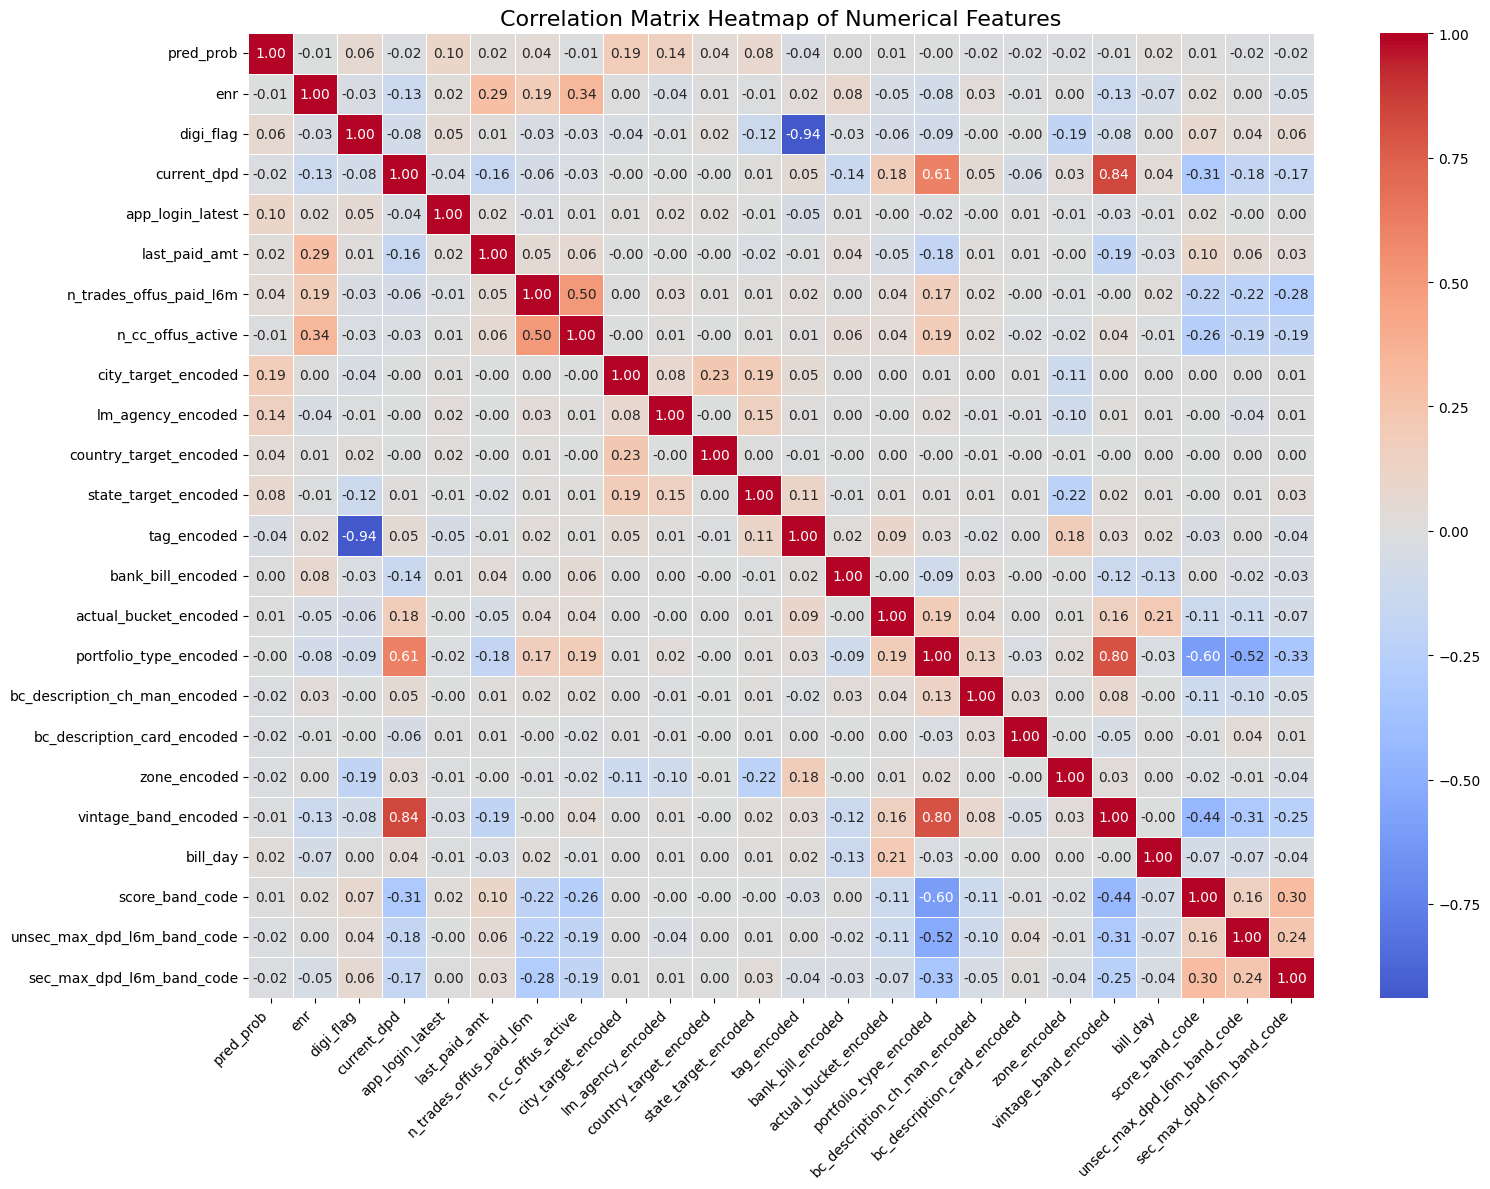

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('preprocessed.csv')  # Replace with your actual file path

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Matrix Heatmap of Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#Model training

In [ ]:
# Tree-based regressors
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
df = pd.read_csv('preprocessed.csv')
X = df.drop(columns=['pred_prob'])
y = df['pred_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds)
    results[name] = {"R²": r2, "RMSE": rmse}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 14083, number of used features: 23
[LightGBM] [Info] Start training from score 0.382255


In [ ]:
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R²', ascending=False))

                    R²      RMSE
LightGBM      0.375339  0.021302
RandomForest  0.344210  0.022364
XGBoost       0.321968  0.023122


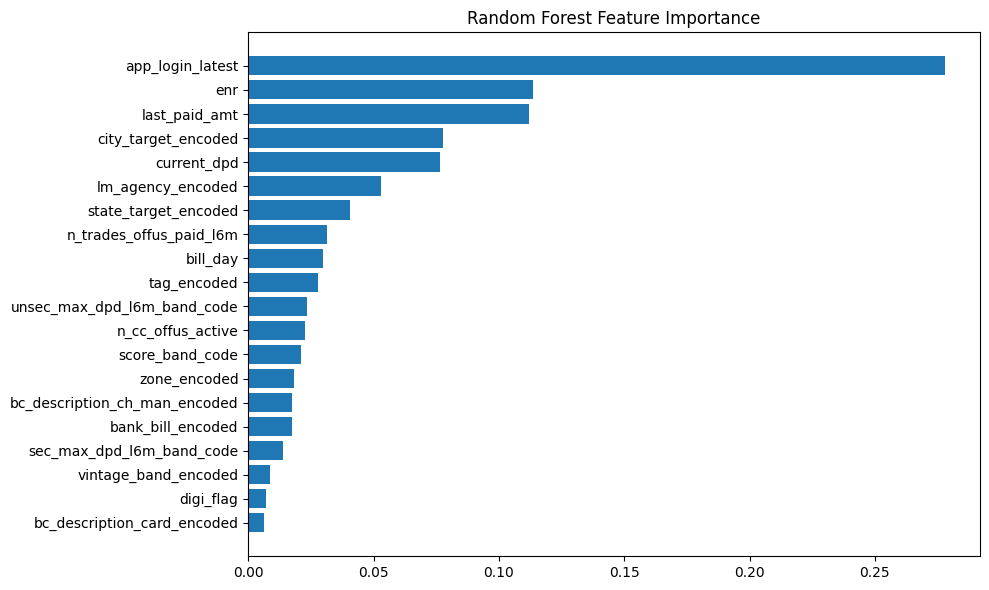

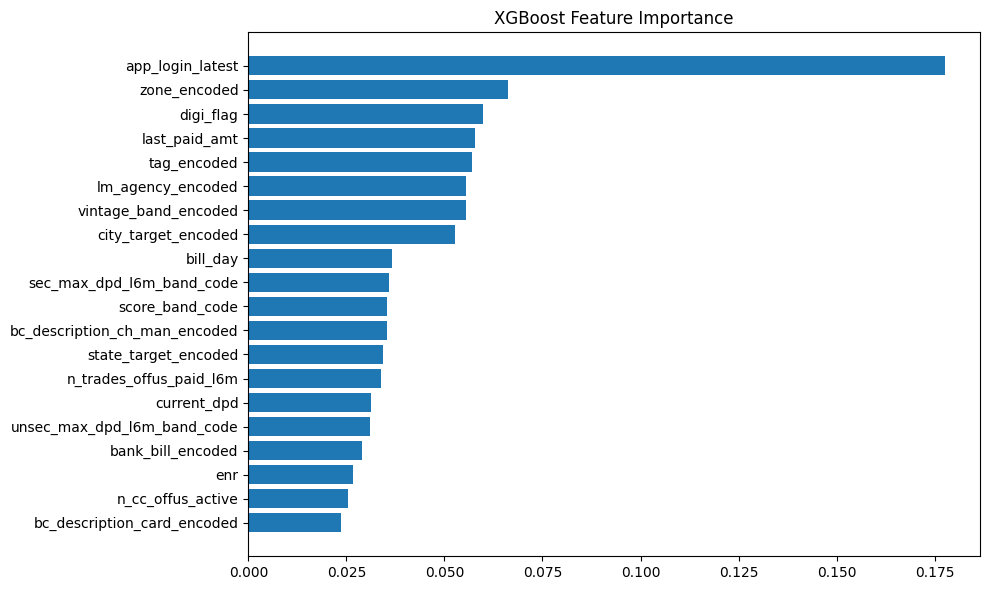

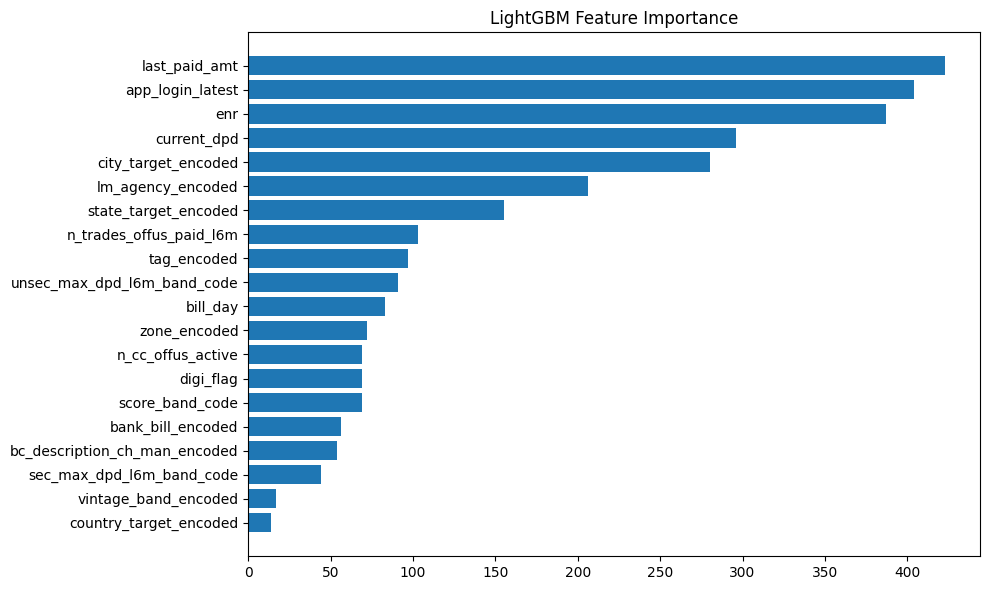

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:]  # top 20
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for each model
plot_feature_importance(models["RandomForest"], X.columns, "Random Forest Feature Importance")
plot_feature_importance(models["XGBoost"], X.columns, "XGBoost Feature Importance")
plot_feature_importance(models["LightGBM"], X.columns, "LightGBM Feature Importance")


we see that LightGBM is the best model here with least MSE and most variance explained (0.37).


It can further be improved by hyperparaemter tuning as shown below.

##Optional


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Define model
lgb = LGBMRegressor(random_state=42)

# Parameter space
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit on imputed train data
random_search.fit(X_train, y_train)

# Best model
best_lgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 14083, number of used features: 23
[LightGBM] [Info] Start training from score 0.382255
Best Parameters: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = best_lgb.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred))


Test R²: 0.3794166115319826
Test RMSE: 0.021163124624653338


In [ ]:
df['pred_prob'] = y

In [ ]:
# Select relevant risk-related features
risk_features = [
    'current_dpd',
    'score_band_code',
    'unsec_max_dpd_l6m_band_code',
    'sec_max_dpd_l6m_band_code',
    'last_paid_amt'
]

# Compute correlation with pred_prob
correlations = df[risk_features + ['pred_prob']].corr()['pred_prob'].sort_values(ascending=False)

print("Correlation of `pred_prob` with risk-related features:")
print(correlations)


Correlation of `pred_prob` with risk-related features:
pred_prob                      1.000000
last_paid_amt                  0.022849
score_band_code                0.006560
unsec_max_dpd_l6m_band_code   -0.015708
sec_max_dpd_l6m_band_code     -0.015855
current_dpd                   -0.016187
Name: pred_prob, dtype: float64


In [ ]:
from sklearn.feature_selection import mutual_info_regression

X = df[['current_dpd', 'score_band_code', 'unsec_max_dpd_l6m_band_code', 'sec_max_dpd_l6m_band_code']]
y = df['pred_prob']

mi = mutual_info_regression(X, y)
for feat, score in zip(X.columns, mi):
    print(f"{feat}: MI score = {score:.4f}")


current_dpd: MI score = 0.0051
score_band_code: MI score = 0.0005
unsec_max_dpd_l6m_band_code: MI score = 0.0070
sec_max_dpd_l6m_band_code: MI score = 0.0000


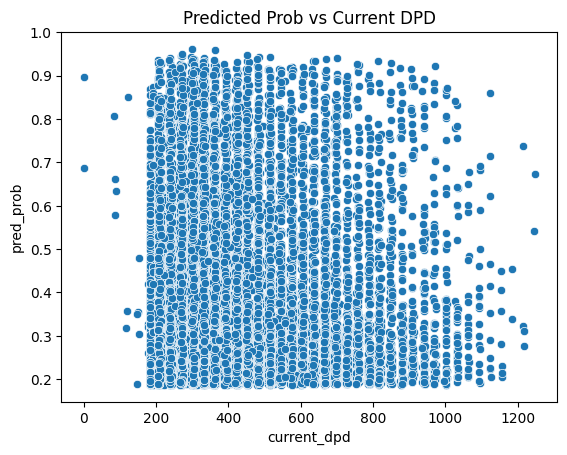

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='current_dpd', y='pred_prob', data=df)
plt.title("Predicted Prob vs Current DPD")
plt.show()

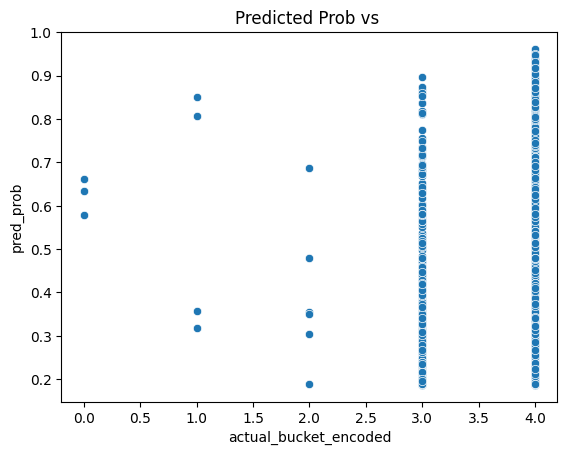

In [ ]:
sns.scatterplot(x='actual_bucket_encoded', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

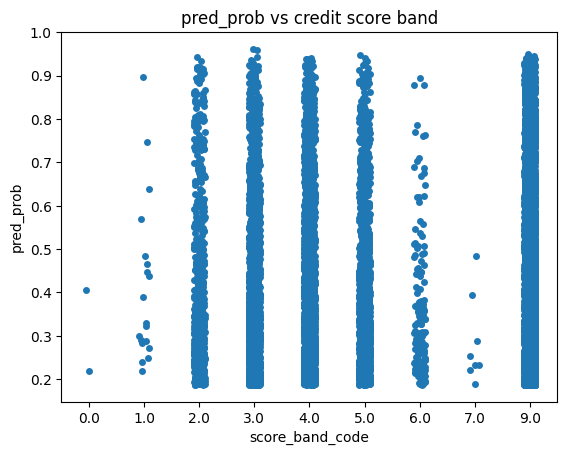

In [ ]:
sns.stripplot(x='score_band_code', y='pred_prob', data=df, jitter=True)
plt.title('pred_prob vs credit score band')
plt.show()

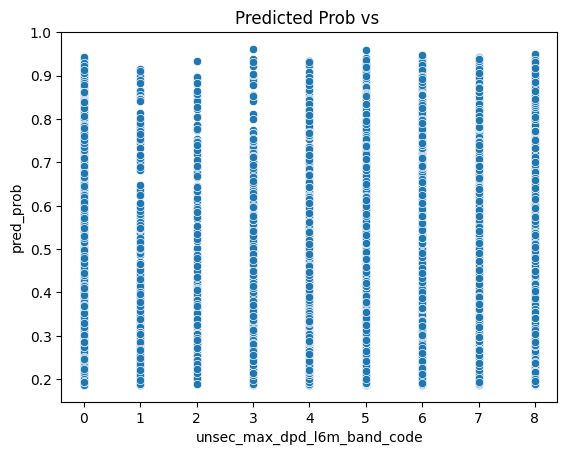

In [ ]:
sns.scatterplot(x='unsec_max_dpd_l6m_band_code', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

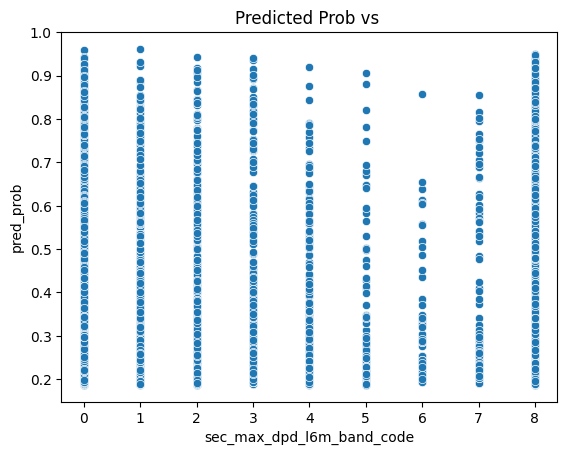

In [ ]:
sns.scatterplot(x='sec_max_dpd_l6m_band_code', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

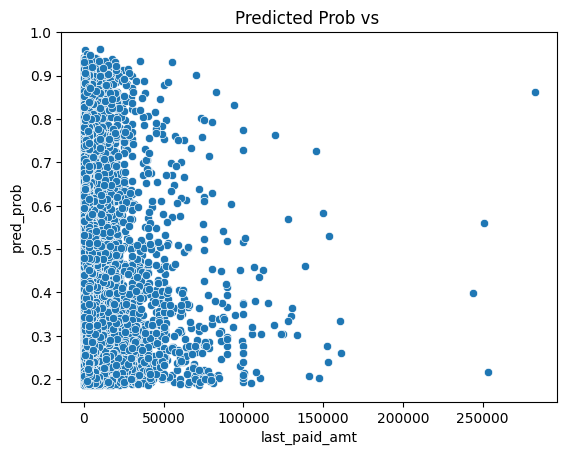

In [ ]:
sns.scatterplot(x='last_paid_amt', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

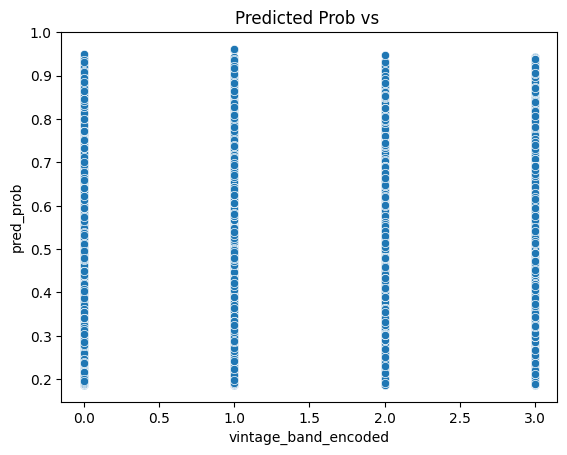

In [ ]:
sns.scatterplot(x='vintage_band_encoded', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

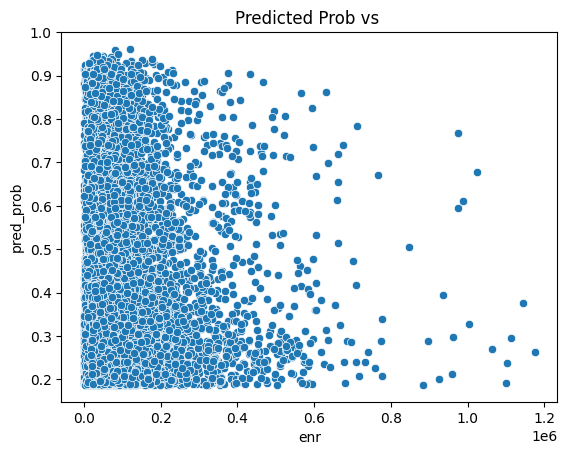

In [ ]:
sns.scatterplot(x='enr', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression

target = 'pred_prob'

# Exclude target and non-numeric columns
numeric_df = df.select_dtypes(include='number').drop(columns=[target])

# Drop rows with missing values (if any)
X = numeric_df.dropna()
y = df.loc[X.index, target]

# Calculate Mutual Information
mi_scores = mutual_info_regression(X, y, discrete_features='auto')

# Combine into DataFrame
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

mi_df.head(20)

,Feature,MI Score
3,app_login_latest,0.185187
7,city_target_encoded,0.046713
11,tag_encoded,0.030783
1,digi_flag,0.024001
4,last_paid_amt,0.013972
10,state_target_encoded,0.007960
21,unsec_max_dpd_l6m_band_code,0.007021
2,current_dpd,0.005659
17,zone_encoded,0.004398
19,bill_day,0.004308


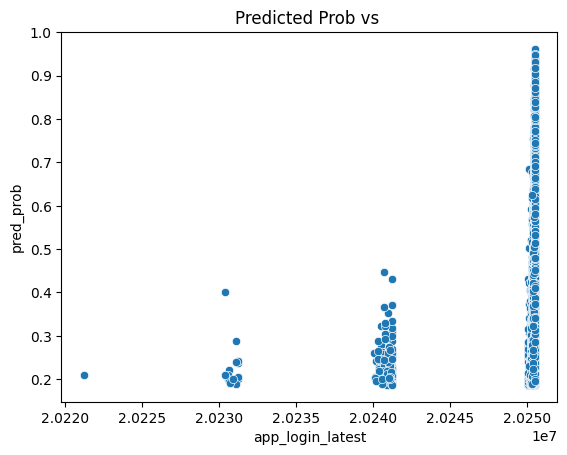

In [ ]:
sns.scatterplot(x='app_login_latest', y='pred_prob', data=df)
plt.title("Predicted Prob vs ")
plt.show()

#Final

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
data=pd.read_csv('/content/data_var (1).csv')
kmeans = KMeans(n_clusters=9, random_state=42)
data['category'] = kmeans.fit_predict(data[['var']])


<Axes: xlabel='category', ylabel='count'>

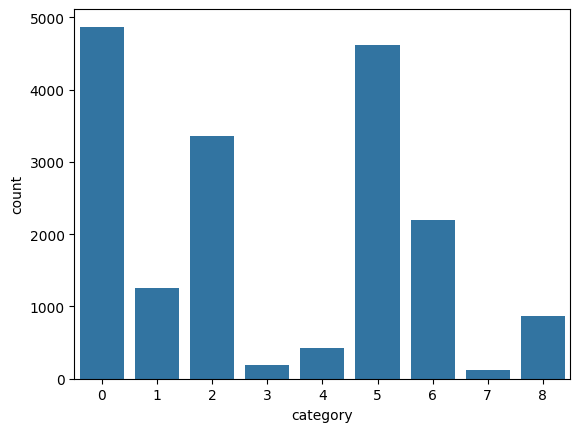

In [ ]:
import seaborn as sns
sns.countplot(x='category', data=data)

In [ ]:
data[data["category"]==0]["var"].mean()

np.float64(8289.931444110522)

In [ ]:
data[data["category"]==1]["var"].mean()

np.float64(77594.56802880937)

In [ ]:
data[data["category"]==2]["var"].mean()

np.float64(35862.3297667951)

In [ ]:
data[data["category"]==3]["var"].mean()

np.float64(200937.52804132126)

In [ ]:
data[data["category"]==4]["var"].mean()

np.float64(146764.65280948541)

In [ ]:
data[data["category"]==5]["var"].mean()

np.float64(20045.76879624657)

In [ ]:
data[data["category"]==6]["var"].mean()

np.float64(54310.80114896028)

In [ ]:
data[data["category"]==7]["var"].mean()

np.float64(278826.9291497617)

In [ ]:
data[data["category"]==8]["var"].mean()

np.float64(106420.37164949557)

7= p1
3=p2
4=p3
8=p4
1=p5
6=p6
2=p7
5=p8
0=p9

In [ ]:
data[data["category"]==4]

,pred_prob,decile,app_latest_city,app_latest_country,state,enr,actual_bucket,digi_flag,city,current_dpd,...,new_tag_encoded,propensity_encoded,portfolio_type_encoded,bill_day,settlement_status_encoded,settlement_status,pbi,lgd,var,category
2,0.198212,8,0.385509,0.385455,0.389048,0.215872,4.0,1,0.389334,274,...,0,1,1,14,4,NaN,0.374,72.94,148461.721503,4
29,0.240567,8,0.395169,0.385455,0.395443,0.239297,4.0,1,0.389334,303,...,1,1,1,16,4,NaN,0.274,70.67,151020.557198,4
38,0.293774,8,0.385509,0.385455,0.395443,0.184751,4.0,1,0.389334,479,...,1,1,1,22,4,NaN,0.678,83.64,128342.456656,4
96,0.207447,8,0.383265,0.385455,0.379453,0.159351,4.0,1,0.365681,514,...,1,1,1,18,4,NaN,0.881,87.34,129734.687942,4
100,0.262961,8,0.363989,0.385455,0.367000,0.213278,4.0,1,0.366915,419,...,1,1,1,22,4,NaN,0.671,81.62,150878.464236,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17682,0.330918,8,0.384146,0.385455,0.384075,0.244572,4.0,1,0.385965,333,...,1,1,1,16,4,NaN,0.731,79.68,153322.118292,4
17693,0.403588,9,0.382086,0.385455,0.380426,0.281251,4.0,1,0.380851,266,...,1,0,0,22,4,NaN,0.771,77.07,152010.334483,4
17760,0.462159,9,0.383265,0.385455,0.383103,0.286640,4.0,1,0.380043,209,...,3,0,0,18,4,NaN,0.771,74.88,135738.257089,4
17825,0.331927,8,0.383265,0.385455,0.383103,0.208562,4.0,1,0.380043,364,...,1,1,1,16,4,NaN,0.621,80.01,131099.802368,4


In [ ]:
data[data["category"]==0]["pred_prob"].mean()

np.float64(0.5013380611899446)

In [ ]:
data[data["category"]==1]["pred_prob"].mean()

np.float64(0.3207320671745407)

In [ ]:
data[data["category"]==2]["pred_prob"].mean()

np.float64(0.34894579306687235)

In [ ]:
data[data["category"]==3]["pred_prob"].mean()

np.float64(0.27878183404274387)

In [ ]:
data[data["category"]==4]["pred_prob"].mean()

np.float64(0.29878767233685277)

In [ ]:
data[data["category"]==5]["pred_prob"].mean()

np.float64(0.3695351212471789)

In [ ]:
data[data["category"]==6]["pred_prob"].mean()

np.float64(0.3220277957654239)

In [ ]:
data[data["category"]==7]["pred_prob"].mean()

np.float64(0.25536570845856604)

In [ ]:
data[data["category"]==8]["pred_prob"].mean()

np.float64(0.3017774078080107)

pred_prob(propensity to pay) is inversely proportional to the var and that is verified by the above means


7= p1 3=p2 4=p3 8=p4 1=p5 6=p6 2=p7 5=p8 0=p9

In [ ]:
label_map = {
    0: 'Priority 9',
    1: 'Priority 5',
    2: 'Priority 7',
    3: 'Priority 2',
    4: 'Priority 3',
    5: 'Priority 8',
    6: 'Priority 6',
    7: 'Priority 1',
    8: 'Priority 4'
}

data['category'] = data['category'].map(label_map)

In [ ]:
data.to_csv('final_results.csv',index=False)

In [ ]:
import google.generativeai as genai

genai.configure(api_key="your-api-key")  # Replace with your actual key
model = genai.GenerativeModel("gemini-2.5-flash-preview-05-20")

def generate_message(row):
  state=row['state']
  city=row['city']
  priority=row['category']
  dpd=row['current_dpd']
  prompt= f"""
    You are an expert AI Financial Assistant for a bank, specializing in empathetic and effective customer communication. Your primary goal is to craft a compliant message that maximizes the customer's propensity to pay while adhering to regulatory guidelines.

    You will be given customer data in a fixed format. Your task is to generate a personalized SMS message by deeply analyzing all provided data points.

    Input Data Format:

    Location: {state},{city}
    DPD: {dpd}
    Priority: {priority}

    Your Core Instructions:

    Adopt a Persona: Based on the Priority and DPD, create a quick mental persona for the customer. A Low-priority(Priority 7, Priority 8, priority 9) customer with low DPD is likely forgetful. A High-priority(priority 1, priority 2,priority 3) customer with high DPD is likely in significant financial distress. Let this persona guide your tone.

    Personalize with Regional Context:

    Language: Write in casual, natural Indian English. Include region specific phrases interspersed in the message

    Greeting: Begin with a warm, respectful greeting in the dominant local language of the Location (e.g., "Namaskar" for Nagpur, "Vanakkam" for Chennai, "Nomoshkar" for Kolkata). Address the customer respectfully.

    Implement a Risk-Tuned Communication Strategy: Your message's structure, tone, and content must directly reflect the customer's Priority. Do not reveal the priority to the customer.
    If Priority is Low:

    Tone: Polite, appreciative, and helpful. Assume it's a simple oversight.
    Psychological Nudge: Use positive reinforcement. Emphasize the benefits of their good payment history and the ease of clearing the due.
    Impact of Non-Payment: Mention this gently and indirectly. Frame it as avoiding an inconvenience. Example: "Just a quick reminder to clear your due of ₹[Amount] to avoid any late fees and keep your account in top shape."
    Call to Action: Provide direct and easy payment links.

    If Priority is Moderate(Priority 4,5,6):

    Tone: Empathetic, supportive, and collaborative. Acknowledge that things can be difficult.
    Psychological Nudge: Build trust and show a willingness to help. Frame the bank as a partner.
    Impact of Non-Payment: Be more direct but supportive. Clearly state the effect on their credit score and future borrowing capacity. Example: "We want to help you avoid a negative impact on your CIBIL score, which can make getting future loans or credit cards difficult."
    Call to Action: Encourage communication. Offer help and provide contact details prominently. Introduce helpful options. Example: "Let's figure this out together. Please call us... We can also discuss options like [mention a specific option]."

    If Priority is High:

    Tone: Firm, formal, and urgent, yet respectful. The tone should convey the seriousness of the situation without being aggressive.
    Psychological Nudge: Use loss aversion. Clearly and unambiguously state the immediate, concrete negative consequences of further non-payment. The focus is on the serious problems they will face if they don't act now.
    Impact of Non-Payment: Be explicit and formal. List the specific, severe next steps. Example: "Please be aware that further delay will compel us to report this default to all major credit bureaus (CIBIL, Experian), severely impacting your credit profile for years. As per your agreement, we may also be forced to initiate formal debt recovery proceedings."
    Call to Action: Create urgency. Set a clear, short deadline for contact or payment.


    Formatting: Generate the message in the requested format [SMS]. Ensure clarity and readability.
    """
  response = model.generate_content(prompt)
  return response.text.strip()



In [ ]:
import pandas as pd
df=pd.read_csv('/content/full_final.csv')

In [ ]:
test_df=df.iloc[:4]

In [ ]:
test_df['message'] = test_df.apply(generate_message, axis=1)

/tmp/ipython-input-7-2307867530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['message'] = test_df.apply(generate_message, axis=1)


In [ ]:
test_df.to_csv('test.csv',index=False)

In [ ]:
for i, msg in enumerate(test_df['message']):
    print(f"\n--- Message {i} ---\n{msg}")



--- Message 0 ---
[SMS]
Khamma Ghani,

We understand things can be tough, and we've noticed your outstanding loan amount from [Your Bank Name] is still pending. Aapka CIBIL score bahut important hai, sahib, aur hum nahi chahte ki ispe koi bura asar pade. Future mein loans ya credit cards lene mein isse dikkat aa sakti hai.

Hum aapke saath milkar iska hal nikalna chahte hain. Please call us immediately at [Customer Service Number] to discuss flexible repayment options like a revised payment plan or a partial settlement. Hum aapki madad ke liye taiyaar hain!

Regards,
[Your Bank Name]

--- Message 1 ---
[SMS]
Namaskaram [Customer Name]! Hope you're doing well. Just a friendly heads-up about a pending payment on your account for ₹[Amount]. Clearing this will keep your account in super good shape and help you avoid any late fees or unnecessary hassles, you know? It's super easy to clear it right away using this link: [Payment Link]. Chalo, let's get it done quickly! Thanks a lot for your